In [1]:
from datetime import datetime as dt
from scipy import signal
import pandas as pd
import numpy as np
import xarray as xr
from siphon.catalog import TDSCatalog
import pandas.tseries.offsets as offsets
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import curve_fit
import seaborn as sns
import scipy as sp
import time
import datetime
from tqdm.notebook import tqdm
from rasterio.plot import show
import coiled
from distributed import Client, LocalCluster

In [2]:
#import ee
#ee.Initialize()
#min_y, min_x = 40.861186515091525, -104.77249563324281
#max_y, max_x =  40.914816304157725, -104.62715563856536

min_y, min_x = 41.25, -105.00
max_y, max_x = 40.25, -104.00

#polygon = ee.Geometry.Polygon([
#    [[min_x, max_y], [max_x, max_y], [max_x, min_y], [min_x, min_y], [min_x, max_y]]
#])

# polygon to feature collection
#fc = ee.FeatureCollection(polygon)
#print("Polygon area is appoximately " + str(np.round(polygon.area().getInfo() / 10000, 1)) + " hectares")

In [3]:
def non_uniform_savgol(x, y, window, polynom):
    """
  Applies a Savitzky-Golay filter to y with non-uniform spacing
  as defined in x

  This is based on https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data
  The borders are interpolated like scipy.signal.savgol_filter would do

  Parameters
  ----------
  x : array_like
      List of floats representing the x values of the data
  y : array_like
      List of floats representing the y values. Must have same length
      as x
  window : int (odd)
      Window length of datapoints. Must be odd and smaller than x
  polynom : int
      The order of polynom used. Must be smaller than the window size

  Returns
  -------
  np.array of float
      The smoothed y values
  """
    if len(x) != len(y):
        raise ValueError('"x" and "y" must be of the same size')

    if len(x) < window:
        raise ValueError('The data size must be larger than the window size')

    if type(window) is not int:
        raise TypeError('"window" must be an integer')

    if window % 2 == 0:
        raise ValueError('The "window" must be an odd integer')

    if type(polynom) is not int:
        raise TypeError('"polynom" must be an integer')

    if polynom >= window:
        raise ValueError('"polynom" must be less than "window"')

    half_window = window // 2
    polynom += 1

    # Initialize variables
    A = np.empty((window, polynom))  # Matrix
    tA = np.empty((polynom, window))  # Transposed matrix
    t = np.empty(window)  # Local x variables
    y_smoothed = np.full(len(y), np.nan)

    # Start smoothing
    for i in range(half_window, len(x) - half_window, 1):
        # Center a window of x values on x[i]
        for j in range(0, window, 1):
            t[j] = x[i + j - half_window] - x[i]

        # Create the initial matrix A and its transposed form tA
        for j in range(0, window, 1):
            r = 1.0
            for k in range(0, polynom, 1):
                A[j, k] = r
                tA[k, j] = r
                r *= t[j]

        # Multiply the two matrices
        tAA = np.matmul(tA, A)

        # Invert the product of the matrices
        tAA = np.linalg.inv(tAA)

        # Calculate the pseudoinverse of the design matrix
        coeffs = np.matmul(tAA, tA)

        # Calculate c0 which is also the y value for y[i]
        y_smoothed[i] = 0
        for j in range(0, window, 1):
            y_smoothed[i] += coeffs[0, j] * y[i + j - half_window]

        # If at the end or beginning, store all coefficients for the polynom
        if i == half_window:
            first_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    first_coeffs[k] += coeffs[k, j] * y[j]
        elif i == len(x) - half_window - 1:
            last_coeffs = np.zeros(polynom)
            for j in range(0, window, 1):
                for k in range(polynom):
                    last_coeffs[k] += coeffs[k, j] * y[len(y) - window + j]

    # Interpolate the result at the left border
    for i in range(0, half_window, 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += first_coeffs[j] * x_i
            x_i *= x[i] - x[half_window]

    # Interpolate the result at the right border
    for i in range(len(x) - half_window, len(x), 1):
        y_smoothed[i] = 0
        x_i = 1
        for j in range(0, polynom, 1):
            y_smoothed[i] += last_coeffs[j] * x_i
            x_i *= x[i] - x[-half_window - 1]

    return y_smoothed

def savgol_ndvi(timeseries, xdate, wnds=[11, 7], orders=[3, 3], limit=None, lwr=False, debug=False):
    # https://gis.stackexchange.com/questions/173721/reconstructing-modis-time-series-applying-savitzky-golay-filter-with-python-nump/173747
    interp_ts = pd.Series(timeseries)
    interp_ts = interp_ts.interpolate(method='linear', limit=limit)
    smooth_ts = interp_ts
    wnd, order = wnds[0], orders[0]
    F = 1e8
    W = None
    it = 0
    while True:
        smoother_ts = non_uniform_savgol(xdate, smooth_ts, window=wnd, polynom=order)
        diff = smoother_ts - interp_ts
        if lwr:
            sign = diff < 0
        else:
            sign = diff > 0
        if W is None:
            W = 1 - np.abs(diff) / np.max(np.abs(diff)) * sign
            wnd, order = wnds[1], orders[1]
        fitting_score = np.sum(np.abs(diff) * W)
        #print(it, ' : ', fitting_score)
        if fitting_score > F:
            break
        else:
            F = fitting_score
            it += 1
        if it > 100:
            break
        smooth_ts = smoother_ts * sign + interp_ts * (1 - sign)
    if debug:
        return smooth_ts, interp_ts
    return smooth_ts


def apply_savgol(ts, window=31, polynom=3, limit=None):
    ts_tmp = ts.copy()
    ts_interp = pd.Series(ts_tmp)
    ts_interp = ts_interp.interpolate(method='linear', limit_area='inside', limit=limit)
    ts_interp = ts_interp.interpolate(method='linear', limit=None, limit_direction='both',
                                      limit_area='outside')
    try:
        ts_smooth = savgol_filter(ts_interp, window_length=window, polyorder=polynom)
    except np.linalg.LinAlgError:
        ts_smooth = ts_interp
    return ts_smooth


def modified_z_score(ts):
    # see https://towardsdatascience.com/removing-spikes-from-raman-spectra-8a9fdda0ac22
    median_int = np.nanmedian(ts)
    mad_int = np.nanmedian([np.abs(ts - median_int)])
    modified_z_scores = 0.6745 * (ts - median_int) / mad_int
    return modified_z_scores


def mask_ts_outliers(ts, threshold=3.5):
    # see https://towardsdatascience.com/removing-spikes-from-raman-spectra-8a9fdda0ac22
    ts_masked = ts.copy()
    ts_modz_robust = np.array(abs(modified_z_score(ts_masked)))
    if not np.all(np.isnan(ts_modz_robust)):
        spikes1 = ts_modz_robust > threshold
        ts_masked[spikes1] = np.nan
    return ts_masked


def despike_ts(dat_ts, dat_thresh, days_thresh, z_thresh=3.5, mask_outliers=False, iters=2):
    dat_ts_cln = dat_ts.copy()
    if mask_outliers:
        dat_ts_cln = mask_ts_outliers(dat_ts_cln, threshold=z_thresh)
    dat_mask = np.zeros_like(dat_ts_cln)
    for i in range(iters):
        for idx in range(len(dat_ts_cln)):
            if not np.isnan(dat_ts_cln[idx]):
                idx_clear = np.where(~np.isnan(dat_ts_cln))[0]
                if idx == np.min(idx_clear):
                    continue
                elif idx == np.max(idx_clear):
                    continue
                else:
                    idx_pre = idx_clear[idx_clear < idx][-1]
                    idx_post = idx_clear[idx_clear > idx][0]
                    y = np.array([dat_ts_cln[idx_pre], dat_ts_cln[idx_post]])
                    x = np.array([idx_pre, idx_post])
                    dx = np.diff(x)
                    dy = np.diff(y)
                    slope = dy / dx
                    dat_interp = dat_ts_cln[idx_pre] + slope[0] * (idx - idx_pre)
                    dat_diff = dat_interp - dat_ts_cln[idx]
                    shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
                    if (idx_post - idx_pre < days_thresh) & (np.abs(dat_diff) > dat_thresh) & (np.abs(shadow_val) > 2):
                        dat_ts_cln[idx] = np.nan
                        dat_mask[idx] = 1
                    else:
                        continue
            else:
                continue
    dat_ts_cln[np.where(dat_mask == 1)] = np.nan
    return dat_ts_cln

def double_logistic(x, vmin, vmax, sos, scaleS, eos, scaleA):
    y = vmin + vmax * ((1 / (1 + np.exp(-scaleS * (x - sos)))) + (1 / (1 + np.exp(scaleA * (x - eos)))) - 1)
    return y

def apply_dl(dat_ts):
    ndvi_smooth = pd.Series(dat_ts)
    try:
        p0 = [ndvi_smooth.quantile(q=0.01),
              np.max(ndvi_smooth),
              int(np.percentile(ndvi_smooth.index, 25)),
              1.0,
              int(np.percentile(ndvi_smooth.index, 75)),
              1.0]  # this is a mandatory initial guess
        popt, pcov = curve_fit(double_logistic, ndvi_smooth.index, ndvi_smooth,
                               p0, method='lm', maxfev=20000)
        ndvi_dl = double_logistic(ndvi_smooth.index, *popt)
    except RuntimeError:
        try:
            p0 = [ndvi_smooth.quantile(q=0.01),
                  np.max(ndvi_smooth),
                  120,
                  1.0,
                  265,
                  1.0]  # this is a mandatory initial guess
            popt, pcov = curve_fit(double_logistic, ndvi_smooth.index, ndvi_smooth,
                                   p0, method='lm', maxfev=20000)
            ndvi_dl = double_logistic(df_ndvi_avhrr.index, *popt)
        except RuntimeError:
            ndvi_dl = ndvi_smooth * np.nan
            print(RuntimeError)
    return ndvi_dl

def savgol_ndvi_xr(dat, dims, double=True, kwargs={}):
    xr_smoothed = xr.apply_ufunc(savgol_ndvi,
                                 dat,
                                 kwargs=kwargs,
                                 input_core_dims=[dims],
                                 output_core_dims=[dims],
                                 dask='parallelized', vectorize=True,
                                 output_dtypes=[float])
    return xr_smoothed

def apply_savgol_xr(dat, dims, double=True, kwargs={}):
    xr_smoothed = xr.apply_ufunc(apply_savgol,
                                 dat,
                                 kwargs=kwargs,
                                 input_core_dims=[dims],
                                 output_core_dims=[dims],
                                 dask='parallelized', vectorize=True,
                                 output_dtypes=[float])
    return xr_smoothed


def despike_ts_xr(dat, dat_thresh, dims, days_thresh=60, z_thresh=3.5, mask_outliers=False, iters=2):
    xr_ds = xr.apply_ufunc(despike_ts,
                           dat,
                           kwargs=dict(dat_thresh=dat_thresh,
                                       days_thresh=days_thresh,
                                       z_thresh=z_thresh,
                                       mask_outliers=mask_outliers,
                                       iters=iters),
                           input_core_dims=[dims],
                           output_core_dims=[dims],
                           dask='parallelized', vectorize=True,
                           output_dtypes=[float])
    return xr_ds

def apply_dl_xr(dat, dims, kwargs={}):
    xr_dl = xr.apply_ufunc(apply_dl,
                                 dat,
                                 kwargs=kwargs,
                                 input_core_dims=[dims],
                                 output_core_dims=[dims],
                                 dask='parallelized', vectorize=True,
                                 output_dtypes=[float])
    return xr_dl

def mask_avhrr_xr(src):
    band_QA = src.astype('int16')

    def unpack_bits(b_num):
        mask = np.subtract(np.divide(band_QA, 2 ** b_num).astype('int'),
                           (np.divide(np.divide(band_QA, 2 ** b_num).astype('int'), 2).astype('int') * 2))
        return mask

    def mask_from_QA(dat, bits):
        return xr.apply_ufunc(unpack_bits, bits).astype('int8')

    cloud_mask = mask_from_QA(band_QA, 1)
    cloud_shadow_mask = mask_from_QA(band_QA, 2)
    water_mask = mask_from_QA(band_QA, 3)
    glint_mask = mask_from_QA(band_QA, 4)
    night_mask = mask_from_QA(band_QA, 6)
    channel_mask = ~(mask_from_QA(band_QA, 7).astype(bool)).astype(int)
    rho_mask = mask_from_QA(band_QA, 13)
    
    all_masks = xr.concat([cloud_mask, cloud_shadow_mask,
                           water_mask, glint_mask, night_mask,
                           channel_mask, rho_mask],
                          dim='time')
    QA_mask_all = all_masks.groupby('time').max()
    return QA_mask_all

def calc_dl(dat_ts, xdate, wnds, limit, dat_thresh, days_thresh, window, polylnom):
    ts_dl = apply_dl(
        despike_ts(
            savgol_ndvi(dat_ts, 
                        xdate=xdate,
                        wnds=wnds,
                        limit=limit),
            dat_thresh=0.07,
            days_thresh=30),
        window=window,
        polynom=polynom,
        limit=limit)
    return ts_dl

def calc_dl_xr(dat):
    xr_dl = xr.apply_ufunc(calc_dl,
                                 dat,
                                 kwargs=kwargs,
                                 input_core_dims=[dims],
                                 output_core_dims=[dims],
                                 dask='parallelized', vectorize=True,
                                 output_dtypes=[float])
    return xr_dl


In [4]:
coiled.create_software_environment(
    name="py_geo",
    conda="py_geo_environment.yaml",
)

Found existing software environment build, returning


In [5]:
#cluster = coiled.Cluster(
#    name="avhrr_cog_coiled",
#        software="py_geo"
#)

In [6]:
cluster_loc = 'local'

if cluster_loc == 'local':
    cluster = LocalCluster(n_workers=8, threads_per_worker=2)
    client = Client(cluster)
    display(client)
elif cluster_loc == 'coiled':
    cluster = coiled.Cluster(
        name="avhrr_cog_coiled",
        software="py_geo",
        n_workers=12,
        worker_cpu=2,
        scheduler_cpu=2)
    client = Client(cluster)
    display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.50 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45453,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.50 GiB
Comm: tcp://127.0.0.1:46045,Total threads: 2
Dashboard: http://127.0.0.1:45457/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:46833,


In [7]:
server_url = 'https://www.ncei.noaa.gov/thredds/'
#request_url = 'cdr/ndvi/files/1982/'
#opendap_url = 'dodsC/'

In [8]:
from siphon.catalog import Dataset
avhrr = xr.open_dataset(server_url + 'dodsC/cdr/ndvi/NDVI-Aggregation.ncml', decode_times=False)

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7feafe973850>>, <Task finished name='Task-13' coro=<Worker.heartbeat() done, defined at /home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/distributed/worker.py:1252> exception=OSError('Timed out during handshake while connecting to tcp://127.0.0.1:45453 after 30 s')>)
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/distributed/comm/tcp.py", line 205, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/asyncio/tasks.py", line 492, in wait_for
    fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct

OSError: [Errno -70] NetCDF: DAP server error: b'https://www.ncei.noaa.gov/thredds/dodsC/cdr/ndvi/NDVI-Aggregation.ncml'

In [ ]:
if avhrr.time.max() > avhrr.time[-1]:
    avhrr = xr.decode_cf(avhrr.drop_sel(time=avhrr.time.max()))
else:
    avhrr = xr.decode_cf(avhrr)

In [11]:
for yr in tqdm(range(1982, 2020)):
    print(yr)
    print('...loading data')
    avhrr_sub = avhrr.sel(time=slice(str(yr) + "-01-01", str(yr) + "-12-31"),
                          latitude=slice(min_y, max_y), 
                          longitude=slice(min_x, max_x)).drop_vars(['crs', 'lat_bnds', 'lon_bnds']).load()
    avhrr_sub = avhrr_sub.chunk({'time': -1,
                                 'longitude': 2,
                                 'latitude': 2})
    print('...masking')
    avhrr_sub['MASK'] = mask_avhrr_xr(avhrr_sub.QA).compute()
    avhrr_sub = avhrr_sub.where(avhrr_sub.MASK == 1).chunk({'time': -1,
                                 'longitude': 2,
                                 'latitude': 2})
    print('...double logistic smoothing')
    avhrr_sub['NDVI_dl'] = calc_dl(avhrr_sub['NDVI_smth2'], dims=['time']).compute()
    print('...converting to dataframe')
    df_tmp = avhrr_sub.to_dataframe().reset_index(drop=False)
    print('...saving to disk')
    df_tmp.to_csv('AVHRR_NDVI_timeseries_' + str(yr) + '.csv', index=False)

In [12]:
for yr in tqdm(range(1982, 2020)):
    print(yr)
    print('...loading data')
    avhrr_sub = avhrr.sel(time=slice(str(yr) + "-01-01", str(yr) + "-12-31"),
                          latitude=slice(min_y, max_y), 
                          longitude=slice(min_x, max_x)).drop_vars(['crs', 'lat_bnds', 'lon_bnds']).load()
    avhrr_sub = avhrr_sub.chunk({'time': -1,
                                 'longitude': 2,
                                 'latitude': 2})
    print('...masking')
    avhrr_sub['MASK'] = mask_avhrr_xr(avhrr_sub.QA).compute()
    avhrr_sub = avhrr_sub.where(avhrr_sub.MASK == 1).chunk({'time': -1,
                                 'longitude': 2,
                                 'latitude': 2})
    print('...running initial NDVI smooth')
    avhrr_sub['NDVI_smth1'] = savgol_ndvi_xr(avhrr_sub.NDVI, dims=['time'], 
                                             kwargs={'xdate': avhrr_sub.time.dt.dayofyear, 
                                                     'wnds': [21, 13],
                                                     'limit': None}).compute()
    print('...despiking')
    avhrr_sub['NDVI_smth1_ds'] = despike_ts_xr(avhrr_sub['NDVI_smth1'], dat_thresh=0.07,
                                               days_thresh=30, dims=['time']).compute()
    print('...smoothing')
    avhrr_sub['NDVI_smth2'] = apply_savgol_xr(avhrr_sub['NDVI_smth1_ds'], dims=['time'], 
                                              kwargs={'window': 31, 
                                                      'polynom': 3,
                                                      'limit': None}).compute()
    print('...fitting double-logistic curve')
    avhrr_sub['NDVI_smth2_dl'] = apply_dl_xr(avhrr_sub['NDVI_smth2'], dims=['time']).compute()
    print('...converting to dataframe')
    df_tmp = avhrr_sub.to_dataframe().reset_index(drop=False)
    print('...saving to disk')
    df_tmp.to_csv('AVHRR_NDVI_timeseries_' + str(yr) + '.csv', index=False)

  0%|          | 0/38 [00:00<?, ?it/s]

1982
...loading data
...masking


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-57746' coro=<WebSocketProtocol13.write_message.<locals>.wrapper() done, defined at /home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/websocket.py:1100> exception=WebSocketClosedError()>
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/websocket.py", line 1102, in wrapper
    await fut
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/websocket.py", line 1104, in wrapper
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError


...running initial NDVI smooth
...despiking


/tmp/ipykernel_8429/3213103961.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])
/tmp/ipykernel_8429/3213103961.py:199: RuntimeWarning: invalid value encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])


...smoothing
...fitting double-logistic curve


/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/distributed/scheduler.py:5622: UserWarning: Scheduler already contains a plugin with name websocket; overwriting.
  warnings.warn(
tornado.application - ERROR - Uncaught exception GET /eventstream (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/eventstream', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/websocket.py", line 954, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/distributed/http/scheduler/info.py", line 201, in open
    self.plugin.add_worker(self.server, worker)
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/distributed/diagnostics/websocket.py", line 20, in add_worker
    self.socket.sen

<class 'RuntimeError'>


UnboundLocalError: local variable 'ndvi_dl' referenced before assignment

In [25]:
print('...fitting double-logistic curve')
avhrr_sub['NDVI_smth2_dl'] = apply_dl_xr(avhrr_sub['NDVI_smth2'], dims=['time']).compute()

...fitting double-logistic curve


/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/distributed/scheduler.py:5622: UserWarning: Scheduler already contains a plugin with name websocket; overwriting.
  warnings.warn(
tornado.application - ERROR - Uncaught exception GET /eventstream (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/eventstream', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/websocket.py", line 954, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/distributed/http/scheduler/info.py", line 201, in open
    self.plugin.add_worker(self.server, worker)
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/distributed/diagnostics/websocket.py", line 20, in add_worker
    self.socket.sen

KeyboardInterrupt: 

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-1393287' coro=<WebSocketProtocol13.write_message.<locals>.wrapper() done, defined at /home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/websocket.py:1100> exception=WebSocketClosedError()>
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/websocket.py", line 1102, in wrapper
    await fut
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_geo_env/lib/python3.9/site-packages/tornado/websocket.py", line 1104, in wrapper
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError


In [23]:
avhrr_sub.drop_vars(['crs', 'lat_bnds', 'lon_bnds']).nbytes / (1024*1024)

10.352912902832031

In [24]:
#avhrr.nbytes / (1024*1024)

4736305.159654617

In [141]:
avhrr_mask_dict = {
    1: 'cloudy',
    2: 'cloud_shadow',
    3: 'water',
    4: 'sunglint',
    5: 'dense_dark_vegetation',
    6: 'night',
    7: 'ch1_to_5_valid',
    8: 'ch1_invalid',
    9: 'ch2_invalid',
    10: 'ch3_invalid',
    11: 'ch4_invalid',
    12: 'ch5_invalid',
    13: 'rho3_invalid',
    14: 'BRDF_corr_problem',
    15: 'polar_flag'
}

b = 16514
def unpack_bits(b_num):
        mask = np.subtract(np.divide(b, 2 ** b_num).astype('int'),
                           (np.divide(np.divide(b, 2 ** b_num).astype('int'), 2).astype('int') * 2))
        return mask
for i in range(1, 16):
    print(avhrr_mask_dict[i] + ': ' + str(unpack_bits(i)))

cloudy: 1
cloud_shadow: 0
water: 0
sunglint: 0
dense_dark_vegetation: 0
night: 0
ch1_to_5_valid: 1
ch1_invalid: 0
ch2_invalid: 0
ch3_invalid: 0
ch4_invalid: 0
ch5_invalid: 0
rho3_invalid: 0
BRDF_corr_problem: 1
polar_flag: 0


In [ ]:
def get_bit(value, bit_index):
    return value & (1 << bit_index)

get_bit(8000, )

0

In [23]:
avhrr_sub.NDVI.isel(time=20).values

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]], dtype=float32)

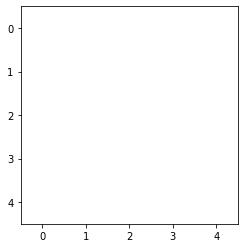

<AxesSubplot:>

In [13]:
avhrr_sub.NDVI.isel(time=20).values
show(avhrr_sub.NDVI.isel(time=140))

In [ ]:
def avhrrMask(image):
    qa = image.select('QA')
    cloudMask = (1 << 0)
    cloudShadowMask = (1 << 2)
    waterMask = (1 << 3)
    glintMask = (1 << 4)
    nightMask = (1 << 6)
    channelMask = (1 << 7)
    rhoMask = (1 << 13)
    brdfMask = (1 << 14)
    maskCloud = qa.bitwiseAnd(cloudMask).eq(0)
    maskCloudShadow = qa.bitwiseAnd(cloudShadowMask).eq(0)
    maskWater = qa.bitwiseAnd(waterMask).eq(0)
    maskGlint = qa.bitwiseAnd(glintMask).eq(0)
    maskNight = qa.bitwiseAnd(nightMask).eq(0)
    maskNDVI = image.gt(0)
    return image.updateMask(maskCloud).updateMask(maskCloudShadow).updateMask(maskWater).updateMask(maskGlint) \
        .updateMask(maskNight).updateMask(maskNDVI) \
        .copyProperties(image, ["system:time_start"])

In [111]:
avhrr_sub['NDVI_smth1'] = savgol_ndvi_xr(avhrr_sub.NDVI, dims=['time'], kwargs={'xdate': ndvi.time.dt.dayofyear, 'wnds': [21, 13]})
avhrr_sub['NDVI_smth1_ds'] = despike_ts_xr(avhrr_sub['NDVI_smth1'], dat_thresh=0.07, days_thresh=30, dims=['time'])
avhrr_sub['NDVI_smth2'] = apply_savgol_xr(avhrr_sub['NDVI_smth1_ds'], dims=['time'], kwargs={'window': 31, 'polynom': 3})
avhrr_sub['NDVI_smth2_dl'] = apply_dl_xr(avhrr_sub['NDVI_smth2'], dims=['time'])

0  :  15.316350587721992
1  :  13.453090105994772
2  :  13.553377694053367
0  :  15.244356536333456
1  :  13.574128848422031
2  :  13.887892721448672


In [21]:
avhrr_sub.dims

Frozen({'latitude': 5, 'longitude': 5, 'ncrs': 1, 'nv': 2, 'time': 357})

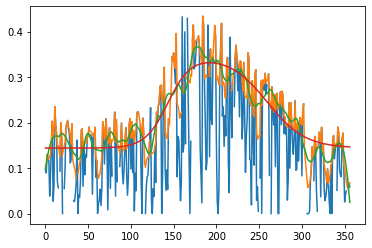

In [24]:
fig, ax = plt.subplots()
ax.plot(avhrr_sub['NDVI'].isel(longitude=1, latitude=1).squeeze().values)
ax.plot(avhrr_sub['NDVI_smth1_ds'].isel(longitude=1, latitude=1).squeeze().values)
ax.plot(avhrr_sub['NDVI_smth2'].isel(longitude=1, latitude=1).squeeze().values)
ax.plot(avhrr_sub['NDVI_smth2_dl'].isel(longitude=1, latitude=1).squeeze().values)


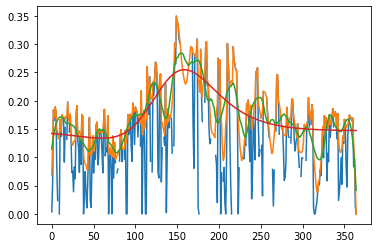

In [110]:
fig, ax = plt.subplots()
ax.plot(test.isel(longitude=1).squeeze().values)
ax.plot(test2.isel(longitude=1).squeeze().values)
ax.plot(test3.isel(longitude=1).squeeze().values)
ax.plot(test4.isel(longitude=1).squeeze().values)


In [22]:
df_ndvi_avhrr_fnl = pd.DataFrame(columns=['Date', 'ndvi', 'ndvi_smooth', 'ndvi_season_dl'])
for yr in range(2020, 2021):
    print(yr)
    # AVHRR image collection over the feature collection and cloudmask
    ndvi_avhrr = ee.ImageCollection("NOAA/CDR/AVHRR/NDVI/V5").filterBounds(fc).map(avhrrMask)
    df_ndvi_avhrr = timeSeriesData(ndvi_avhrr, setData, name='ndvi', band_name='NDVI',
                                   date_range=[str(yr) + '-01-01',
                                               str(yr) + '-12-31'])
    df_ndvi_avhrr['Date'] = pd.to_datetime(df_ndvi_avhrr['Date'])
    df_ndvi_avhrr['ndvi_smooth'] = apply_savgol(
        despike_ts(
            np.array(
                savitzky_golay_filtering(
                    df_ndvi_avhrr.index, df_ndvi_avhrr['ndvi'], wnds=[21, 13])),
            dat_thresh=1000, days_thresh=30),
        window=31, polynom=3)

    try:
        p0 = [df_ndvi_avhrr['ndvi_smooth'].quantile(q=0.01),
              np.max(df_ndvi_avhrr['ndvi_smooth']),
              int(np.percentile(df_ndvi_avhrr.index, 25)),
              1.0,
              int(np.percentile(df_ndvi_avhrr.index, 75)),
              1.0]  # this is a mandatory initial guess
        popt, pcov = curve_fit(double_logistic, df_ndvi_avhrr.index, df_ndvi_avhrr['ndvi_smooth'],
                               p0, method='lm', maxfev=20000)
        df_ndvi_avhrr['ndvi_season_dl'] = double_logistic(df_ndvi_avhrr.index, *popt)
    except RuntimeError:
        try:
            p0 = [df_ndvi_avhrr['ndvi_smooth'].quantile(q=0.01),
                  np.max(df_ndvi_avhrr['ndvi_smooth']),
                  120,
                  1.0,
                  int(np.percentile(df_ndvi_avhrr.index, 75)),
                  1.0]  # this is a mandatory initial guess
            popt, pcov = curve_fit(double_logistic, df_ndvi_avhrr.index, df_ndvi_avhrr['ndvi_smooth'],
                                   p0, method='lm', maxfev=20000)
            df_ndvi_avhrr['ndvi_season_dl'] = double_logistic(df_ndvi_avhrr.index, *popt)
        except RuntimeError:
            print(RuntimeError)

    df_ndvi_avhrr_fnl = df_ndvi_avhrr_fnl.append(df_ndvi_avhrr)



2020
0  :  3901.281785941927
1  :  3191.331193665681
2  :  3541.338152560251


In [23]:
df_ndvi_avhrr_fnl

,Date,ndvi,ndvi_smooth,ndvi_season_dl
0,2020-01-02,70.714432,66.751032,58.752216
1,2020-01-03,46.757074,67.936598,58.755841
2,2020-01-04,54.941117,68.897894,58.760295
3,2020-01-05,77.870721,69.652300,58.765763
4,2020-01-06,52.569993,70.217197,58.772477
...,...,...,...,...
354,2020-12-26,60.794252,70.800874,58.736435
355,2020-12-27,72.237107,70.513963,58.736435
356,2020-12-28,56.606464,70.107671,58.736435
357,2020-12-29,77.839242,69.577714,58.736435
